In [217]:
import pandas as pd
from os.path import join
import regex as re
import string
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy import displacy
from datetime import datetime, timezone
import pytz
import dateutil.parser as dparser
import en_core_web_sm

sns.set_theme()

from nltk.tokenize import word_tokenize

DATA_PATH = 'data/'
EMAIL_DATA = 'Emails.csv'



Read dataframe

In [170]:
def parse_date(date):
    date_parsed = None
    try:
        date_parsed = dparser.parse(date)
        date_parsed = date_parsed.replace(tzinfo=pytz.timezone("US/Pacific"))
        date_parsed = date_parsed.astimezone()
    except:
        pass
    return date_parsed


df = pd.read_csv(join(DATA_PATH, EMAIL_DATA))

# Subset useful fields
df = df[['Id', 'SenderPersonId', 'MetadataDateSent',
         'ExtractedSubject', 'ExtractedBodyText']]
# Preprocess dataframe data
df = df.astype({'Id': int})
df = df.set_index('Id')
df["MetadataDateSent"] = df["MetadataDateSent"].apply(parse_date)


# Drop na values based on Extracted body
len_before = len(df)
df = df[df['ExtractedBodyText'].notna()]
print(f"Number of NA values in body: {len_before - len(df)}.\nNumber of valid email: {len(df)}")
df.head()

Number of NA values in body: 1203.
Number of valid email: 6742


,SenderPersonId,MetadataDateSent,ExtractedSubject,ExtractedBodyText
Id,,,,
2,NaN,2011-03-03 13:53:00+01:00,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
3,32.0,2012-09-12 13:53:00+02:00,Re: Chris Stevens,Thx
5,80.0,2011-03-11 13:53:00+01:00,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
6,80.0,2012-09-12 13:53:00+02:00,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
8,80.0,2011-03-11 13:53:00+01:00,NaN,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


Date and time distribution.

Since the emails belong to Hilary Clinton's personal account instead of the institutional one, we should notice few emails sent during weekdays.

/Users/gianlucagiudice/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

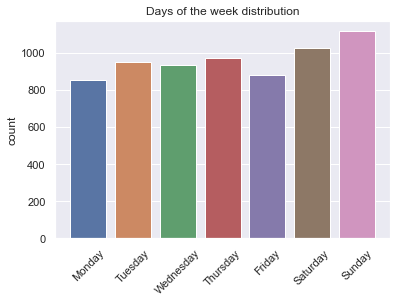

In [215]:
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days = [date.strftime("%A") for date in df[df["MetadataDateSent"].notnull()]["MetadataDateSent"]]
days_freq = pd.Series(days).value_counts()
sns.countplot(days, order=days_order)
plt.xticks(rotation=45)
plt.title("Days of the week distribution")
plt.plot()

Day of the week distribution



Preprocessing

In [15]:
# Body preprocessing
def clean_body(body):
    email_header = re.compile(r'.+[^<]+<[^>]+>', re.IGNORECASE)
    re_header = re.compile(r'(Delivered:\s+)?RE:[^\n]+\n', re.IGNORECASE)
    fw_header = re.compile(r'FW:[^\n]+\n', re.IGNORECASE)
    date_header = re.compile(r'\w+,\s\w+\s\d+,\s\d+[^\n]+\n', re.IGNORECASE)
    # Convert to lowercase
    body = body.lower()
    # Remove email
    body = re.sub(email_header, '', body).strip()
    # Remove "FW:"
    body = re.sub(fw_header, '', body).strip()
    # Remove "RE:"
    body = re.sub(re_header, '', body).strip()
    # Remove date
    body = re.sub(date_header, '', body).strip()
    return body

sample = df['ExtractedBodyText'].loc[230]
print('>>> Raw:\n' + sample)
print('>>> Cleaned:\n' + clean_body(sample))

>>> Raw:
Brennan, John 0.
Subject: RE: Google and YouTube
Sue just called back and the block will stay through Monday. They will not/not be unblocking it before then.
Nora Toiv
Office of the Secretary
202-647-8633
>>> Cleaned:
brennan, john 0.
subject: sue just called back and the block will stay through monday. they will not/not be unblocking it before then.
nora toiv
office of the secretary
202-647-8633


Drop the emails that are too short

In [16]:
def tokenize_body(body):
    tokenized = word_tokenize(body)
    # Strip tokens
    tokenized = [token.strip() for token in tokenized]

    # --------- STRICT RULE ---------
    # Strict regex rule
    tokenized = [token for token in tokenized if re.match('\w+', token)]
    # --------- STRICT RULE ---------

    # Remove punctuation
    tokenized = [token for token in tokenized if token not in string.punctuation]
    # Remove stopwords
    stop = stopwords.words('english') + [':', '.', '@'] + ["n't"]
    tokenized = [token for token in tokenized if token not in stop]
    # Remove numbers
    tokenized = [token for token in tokenized if not re.search(r'\d', token)]
    return tokenized

to_tokenize = clean_body(sample)
tokenize_body(to_tokenize)

['brennan',
 'john',
 'subject',
 'sue',
 'called',
 'back',
 'block',
 'stay',
 'monday',
 'not/not',
 'unblocking',
 'nora',
 'toiv',
 'office',
 'secretary']

In [19]:
def process_body(body):
    body = clean_body(body)
    tokenized = tokenize_body(body)
    return tokenized

In [20]:
df['Tokenized'] = df['ExtractedBodyText'].apply(process_body)

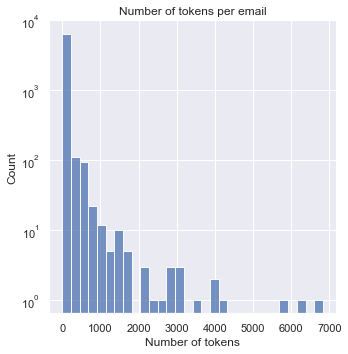

Describe tokens length: count    6742.000000
mean       46.242510
std       232.724065
min         0.000000
25%         2.000000
50%         6.500000
75%        16.000000
max      6832.000000
Name: TokensLength, dtype: float64


In [56]:
df['TokensLength'] = [len(x) for x in df['Tokenized']]

ax = sns.displot(df['TokensLength'], log=True, bins=30)
ax.set_xlabels("Number of tokens")
plt.title("Number of tokens per email")
plt.show()
print("Describe tokens length:", df['TokensLength'].describe())

Wordcloud of the emails with few tokens

In [97]:
TOKENS_THLD = 7
def flatten_tokens(tokens_list):
    words_flatten = []
    for token in tokens_list:
        words_flatten += token
    return pd.Series(words_flatten)

words_flatten = flatten_tokens(df[df["TokensLength"] < TOKENS_THLD]["Tokenized"])
few_words_freq = words_flatten.value_counts()

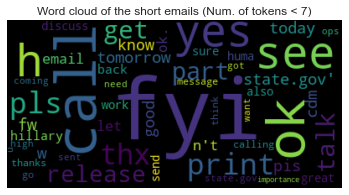

In [112]:
wordcloud = WordCloud(max_font_size=100, max_words=50)
wordcloud = wordcloud.generate_from_frequencies(few_words_freq)
plt.figure()
plt.title(f"Word cloud of the short emails (Num. of tokens < {TOKENS_THLD})")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Analyze the valid emails

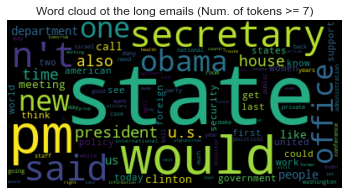

In [114]:
words_flatten = flatten_tokens(df[df["TokensLength"] > TOKENS_THLD]["Tokenized"])
valid_emails_freq = words_flatten.value_counts()

wordcloud = WordCloud(max_font_size=100, max_words=100)
wordcloud = wordcloud.generate_from_frequencies(valid_emails_freq)
plt.figure()
plt.title(f"Word cloud ot the long emails (Num. of tokens >= {TOKENS_THLD})")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Named entity Recognition and linking on nations

In [222]:
nlp = en_core_web_sm.load()

def extract_entities(email_body):
    return [(ent.text, ent.label_) for ent in nlp(email_body).ents]

df["Entities"] = df["ExtractedBodyText"].apply(extract_entities)

In [223]:
df["Entities"]

Id
2       [(Thursday, March 3, 2011, DATE), (Syria, GPE)...
3                                                      []
5       [(Friday, March 11, 2011 1:36 PM\n, DATE), (Hu...
6       [(Wednesday, September 12, 2012 2:11 PM\n, DAT...
8       [(Friday, March 11, 2011 1:36 PM\n, DATE), (Hu...
                              ...                        
7939    [(a very good day, DATE), (Mexico, GPE), (Todd...
7940                                                   []
7942    [(Senate, ORG), (Reid, PERSON), (Saturday, DAT...
7944    [(PVerveer B6, ORG), (Friday, December 17, 201...
7945                                                   []
Name: Entities, Length: 6742, dtype: object

Named entity Recognition and linking on dates to find hilary's schedule of the day